In [1]:
import Bio.SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
import dna_features_viewer
import matplotlib.pyplot as plt

In [2]:
seqs = list(Bio.SeqIO.parse('Spike_prots.fasta', 'fasta'))
seqs

[SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT', SingleLetterAlphabet()), id='Spike', name='Spike', description='Spike', dbxrefs=[]),
 SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...AYT', SingleLetterAlphabet()), id='Spike-ALAYT', name='Spike-ALAYT', description='Spike-ALAYT', dbxrefs=[]),
 SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ICI', SingleLetterAlphabet()), id='Spike-HAtail', name='Spike-HAtail', description='Spike-HAtail', dbxrefs=[])]

Code to translate to `dna_features_viewer` images:

In [3]:
SPIKE_FEATURE_COLOR_MAP = {
        'signal peptide': 'lightsteelblue',
        'S1': 'darkblue',
        'S2': 'cornflowerblue',
        'cytoplasmic tail': 'cyan',
        }
"""dict: Maps Spike features to matplotlib color names."""


class SpikeTranslator(dna_features_viewer.BiopythonTranslator):
    """Translat BioPython SeqRecord to dna_features_viewer graphic record.
    
    Parameters
    -----------
    feature_color_map : dict
        Maps features to color schemes.
    missing_color : str or None
        What if a feature does not have color specified?. If `None` raise
        error, if str make that color.
    
    """
    def __init__(self, feature_color_map, missing_color):
        self.feature_color_map = feature_color_map.copy()
        self.missing_color = missing_color
        super().__init__()
        
    def compute_feature_color(self, feature):
        """Get feature color based on its type."""
        if feature.type in self.feature_color_map:
            return self.feature_color_map[feature.type]
        elif self.missing_color is None:
            raise ValueError(f"no color for feature type {feature.type}")
        else:
            return self.missing_color

Below Most features are annotated using the definitions in [Figure S5 of Wrapp et al (2020)](https://science.sciencemag.org/content/sci/suppl/2020/02/18/science.abb2507.DC1/abb2507-Wrapp-SM.pdf).
The cytoplasmic tail is annotated using the definition for SARS-CoV in [Figure 1 of Sadasivan et al (2017)](https://www.ias.ac.in/article/fulltext/jbsc/042/02/0231-0244).

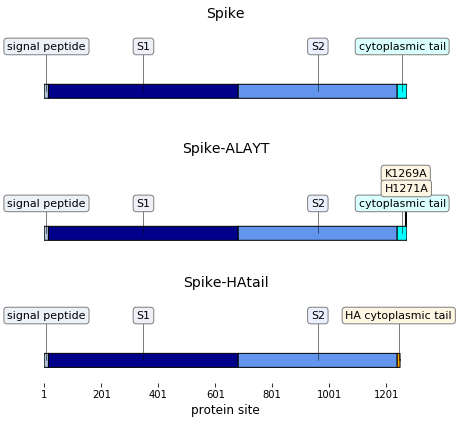

In [4]:
fig, axes = plt.subplots(len(seqs),
                         1,
                         figsize=(6.5, 2.2 * len(seqs)),
                         sharex=True,
                         gridspec_kw={'hspace': 0.5},)

wt_spike_seq = [str(seq.seq) for seq in seqs if seq.name == 'Spike']
assert len(wt_spike_seq) == 1
wt_spike_seq = wt_spike_seq[0]

for seq, ax in zip(seqs, axes):
    seq.features = [
        SeqFeature(type='signal peptide',
                   location=FeatureLocation(0, 15),
                   strand=0),
        SeqFeature(type='S1',
                   location=FeatureLocation(15, 681),
                   strand=0),
        SeqFeature(type='S2',
                   location=FeatureLocation(681, 1239),
                   strand=0),
        ]
    
    if seq.name in {'Spike', 'Spike-ALAYT'}:
        seq.features.append(
                SeqFeature(type='cytoplasmic tail',
                   location=FeatureLocation(1239, len(seq)),
                   strand=0)
                )
        if seq.name == 'Spike-ALAYT':
            spike_seq = str(seq.seq)
            assert len(spike_seq) == len(wt_spike_seq)
            seq.features += [
                SeqFeature(type=f"{wt}{i + 1}{mut}",
                            location=FeatureLocation(i, i + 1),
                            strand=0)
                for i, (wt, mut) in enumerate(zip(wt_spike_seq, spike_seq))
                if wt != mut
                ]
    elif seq.name == 'Spike-HAtail':
        seq.features.append(
                SeqFeature(type='HA cytoplasmic tail',
                   location=FeatureLocation(1239, len(seq)),
                   strand=0)
                )
    else:
        raise ValueError(f"invalid name {seq.name}")
    
    graphic_record = SpikeTranslator(feature_color_map=SPIKE_FEATURE_COLOR_MAP,
                                     missing_color='orange',
                                     ).translate_record(seq)
    ax, _ = graphic_record.plot(ax=ax)
    xmax = max(len(seq) for seq in seqs)
    ax.set_xlim(0, xmax)
    if seq.name != seqs[-1].name:
        ax.tick_params(bottom=False)
    else:
        ax.set_xticks([i for i in range(0, xmax, 200)])
        ax.set_xticklabels([int(i + 1) for i in ax.get_xticks()])
        ax.set_xlabel('protein site', size=12)
    ax.set_title(seq.name, fontsize=14)

plt.savefig('Spike_schematics.pdf', bbox_inches='tight')